# VMTutorial Example

## Self-propelled cell

In this example, we load a configuration of $N=100$ cells with average area set to 1 placed in a simulation box with periodic boundaries. All cells but are are labelled as ''passive''. One cells is labelled as ''active''.

We use the standard vertex model with energy given as $$E = \frac{1}{2}\sum_c\left[\kappa(A_c - A_0)^2 + \Gamma P_c^2 - \Lambda P_c\right],$$where $\kappa$ is the area modulus, $\Gamma$ is the perimeter modulus, and $\Lambda = 2\Gamma P_0$.

The equation of motion for vertex $i$ is $$\eta\dot{\mathbf{r}}_i = \frac{f_0}{N_\text{v}} \mathbf{n}_C \delta_{C,\text{active}} -\nabla_{\mathbf{r}_i}E,$$where $\eta$ is the friction coefficient between the vertex and the substrate. Term $\frac{f_0 }{N_\text{v}} \mathbf{n}_C \delta_{C,\text{active}}$  denotes that the active cells is self-propelled with the force of magnitude $f_0$ along the direction set by the director vector $\mathbf{n}_C$ assigned to each cell. The self propulsion force on the vertex is then $\frac{1}{N_\text{v}} \mathbf{n}_C$, where $N_\text{v}$ is the number of vertices in cell $C$. The Kronecker delta $\delta_{C,\text{active}}$ is used to indicate that the self-propulsion force is applied to the active cell only.

In the actual simulation, we'll set $\eta = 1$, and define $v_0 = f_0/\eta$.

### Loading the VM simulation module

In [1]:
from VMToolkit.VM import *

Loading auxiliary modules

In [2]:
import numpy as np

### Parameters

Simulation parameters

In [3]:
input_file = 'random_normal_sp.json'
dt = 0.05
rng_seed = 11122023
p0 = 3.85
v0 = 2.0
dumpfreq = 1
nrelax = 50
nrun = 500
eta = 1.0 

### Simulation initialisation

We now set the simulation object that will constrol the execution.

In [4]:
tissue  = Tissue()                                               # initialise mesh
sim_sys = System(tissue)                                         # base object for the system
forces = Force(sim_sys)                                          # handles all types of forces
integrators = Integrate(sim_sys, forces, rng_seed)               # handles all integrators
topology = Topology(sim_sys, forces)                             # handles all topology changes (T1, division, ingression)
dumps = Dump(sim_sys, forces)                                    # handles all data output 
simulation = Simulation(sim_sys, integrators, forces, topology)  # simulation object

We proceed to read in the data.

In [5]:
sim_sys.read_input(input_file)

Setting periodic simulation box.
Finished reading vertices.
Finished reading faces.
Finished mesh setup.
Mesh has 200 vertices 300 edges and 100 faces.
Finished reading input configuration.


We now compute the mean cell area to be able to set the simulation parameters

In [6]:
A0 = 0.0
for c in tissue.cells():
    A0 += tissue.cell_area(c.id)
A0 /= len(tissue.cells())

We now plot it to see how it looks like.

In [8]:
from tissue_plot import make_plotter
make_plotter(tissue, cmap='viridis', colourby='type').show()

Widget(value="<iframe src='http://localhost:50354/index.html?ui=P_0x309cfc8b0_1&reconnect=auto' style='width: …

 JS Error => Malformed message:  {"wslink": "1.0", "id": "publish:trame.vtk.delta:0", "result": {"parent": "0x0", "id": 2, "type": "vtkCocoaRenderWindow", "properties": {"numberOfLayers": 2}, "dependencies": [{"parent": "000000031135cfc0", "id": "00000003090c7000", "type": "vtkOpenGLRenderer", "properties": {"background": [1.0, 1.0, 1.0], "background2": [0.2, 0.2, 0.2], "viewport": [0.0, 0.0, 1.0, 1.0], "twoSidedLighting": 1, "lightFollowCamera": 1, "layer": 0, "preserveColorBuffer": 0, "preserveDepthBuffer": 0, "nearClippingPlaneTolerance": 0.001, "clippingRangeExpansion": 0.5, "useShadows": 0, "useDepthPeeling": 0, "occlusionRatio": 0.0, "maximumNumberOfPeels": 4, "interactive": 1}, "dependencies": [{"parent": "00000003090c7000", "id": "00000001739fc2c0", "type": "vtkOpenGLCamera", "properties": {"focalPoint": [0.006682963030616662, -0.10103063231411324, 0.0], "position": [0.006682963030616662, -0.10103063231411324, 26.328218053067417], "viewUp": [0.0, 1.0, 0.0], "clippingRange": [24

We can not set the values of simulation parameters.

In [9]:
kappa = 1.0
gamma = 1.0
lam = p0 * np.sqrt(A0) * gamma

### Add model (force) and assign parameter values

In [10]:
forces.add('area')         # add area force form term E = 0.5*kappa*(A-A0)^2
forces.add('perimeter')    # add perimeter force term from E = 0.5*gamma*P^2 - lambda*P 

Assign parameters to cell types 'passive' and 'active' (we use same parameters in both cases)

In [11]:
forces.set_params('area', 'passive', {'kappa' : kappa})
forces.set_params('area', 'active', {'kappa' : kappa})

forces.set_params('perimeter', 'passive',  {'gamma': gamma, 'lambda': lam})   
forces.set_params('perimeter', 'active',  {'gamma': gamma, 'lambda': lam})   

Set the unit of time and the time step

In [12]:
eta = 1.0 # friction coefficient
tau = eta/(kappa*A0) # characteristic time scale
dt = dt*tau
nsteps = int(round(1/dt))   # number of steps to run is set to tau

### Set topology change (i.e. T1 transition) conditions

In [13]:
topology.set_params({'min_edge_len': 0.01, 'new_edge_len': 0.011}) 

### Add integrator for the equations of motion (Brownian dynamics)

In [14]:
integrators.add('brownian') 

Set the timestep

In [15]:
integrators.set_dt(dt)

### First we do relaxation without self-propulsion

In [16]:
print('Running relaxation...')
for i in range(0, nrelax):
   if i % dumpfreq == 0:
      dumps.dump_cells(f'relax_p0_{p0:.3f}_v0_{v0:.2f}_{i:06d}.vtp', draw_periodic=True)
   simulation.run(nsteps)

print('Relaxation done...')

Running relaxation...
[========================================] 100%  --> Completed 20 simulation steps 
[========================================] 100%  --> Completed 40 simulation steps 
[========================================] 100%  --> Completed 60 simulation steps 
[========================================] 100%  --> Completed 80 simulation steps 
[========================================] 100%  --> Completed 100 simulation steps 
[========================================] 100%  --> Completed 120 simulation steps 
[========================================] 100%  --> Completed 140 simulation steps 
[========================================] 100%  --> Completed 160 simulation steps 
[========================================] 100%  --> Completed 180 simulation steps 
[========================================] 100%  --> Completed 200 simulation steps 
[========================================] 100%  --> Completed 220 simulation steps 
[========================================] 100%

### Add self propulsion in the horizontal direction to the active cell

In [19]:
#forces.add('self-propulsion') # add self-propulsion force term

#----------- Force parameters --------------------------------------
forces.set_params('self-propulsion', 'active', {'v0': v0})
forces.set_vec_params('self-propulsion', 'active', {'n': Vec(1.0, 0.0)})  # set the direction of self-propulsion

### Exectute simulation

We also produce output as vtp and json files for detailed visualisation and analysis.

In [20]:
print('Running self-propulsion simulation...')
for i in range(0, nrun):
   if i % dumpfreq == 0:
      dumps.dump_cells(f'cells_p0_{p0:.3f}_v0_{v0:.2f}_{i:06d}.vtp', draw_periodic=True)
      dumps.dump_cell_directors(f'dir_p0_{p0:.3f}_v0_{i:06d}.vtp', draw_periodic=True)
   simulation.run(nsteps)

Running self-propulsion simulation...
[========================================] 100%  --> Completed 1020 simulation steps 
[========================================] 100%  --> Completed 1040 simulation steps 
[========================================] 100%  --> Completed 1060 simulation steps 
[========================================] 100%  --> Completed 1080 simulation steps 
[========================================] 100%  --> Completed 1100 simulation steps 
[========================================] 100%  --> Completed 1120 simulation steps 
[========================================] 100%  --> Completed 1140 simulation steps 
[========================================] 100%  --> Completed 1160 simulation steps 
[========================================] 100%  --> Completed 1180 simulation steps 
[========================================] 100%  --> Completed 1200 simulation steps 
[========================================] 100%  --> Completed 1220 simulation steps 
[===============

[========================================] 100%  --> Completed 10840 simulation steps 
[========================================] 100%  --> Completed 10860 simulation steps 
[========================================] 100%  --> Completed 10880 simulation steps 
[========================================] 100%  --> Completed 10900 simulation steps 
[========================================] 100%  --> Completed 10920 simulation steps 
[========================================] 100%  --> Completed 10940 simulation steps 
[========================================] 100%  --> Completed 10960 simulation steps 
[========================================] 100%  --> Completed 10980 simulation steps 
[========================================] 100%  --> Completed 11000 simulation steps 


### Visualisation post relaxation

We can now take a look into the relaxed configuration

In [21]:
make_plotter(tissue, cmap='viridis', colourby='type').show()

Widget(value="<iframe src='http://localhost:50354/index.html?ui=P_0x329a7bf10_2&reconnect=auto' style='width: …

Exception raised
ConnectionResetError('Cannot write to closing transport')
Traceback (most recent call last):
  File "/Users/RSknepnek/opt/anaconda3/envs/py310/lib/python3.10/site-packages/wslink/protocol.py", line 340, in onMessage
    await self.sendWrappedMessage(
  File "/Users/RSknepnek/opt/anaconda3/envs/py310/lib/python3.10/site-packages/wslink/protocol.py", line 484, in sendWrappedMessage
    await ws.send_str(encMsg)
  File "/Users/RSknepnek/opt/anaconda3/envs/py310/lib/python3.10/site-packages/aiohttp/web_ws.py", line 336, in send_str
    await self._writer.send(data, binary=False, compress=compress)
  File "/Users/RSknepnek/opt/anaconda3/envs/py310/lib/python3.10/site-packages/aiohttp/http_websocket.py", line 723, in send
    await self._send_frame(message, WSMsgType.TEXT, compress)
  File "/Users/RSknepnek/opt/anaconda3/envs/py310/lib/python3.10/site-packages/aiohttp/http_websocket.py", line 686, in _send_frame
    self._write(header + message)
  File "/Users/RSknepnek/opt/

 JS Error => Malformed message:  {"wslink": "1.0", "id": "publish:trame.vtk.delta:0", "result": {"parent": "0x0", "id": 3, "type": "vtkCocoaRenderWindow", "properties": {"numberOfLayers": 2}, "dependencies": [{"parent": "000000012af99d70", "id": "000000012b924a00", "type": "vtkOpenGLRenderer", "properties": {"background": [1.0, 1.0, 1.0], "background2": [0.2, 0.2, 0.2], "viewport": [0.0, 0.0, 1.0, 1.0], "twoSidedLighting": 1, "lightFollowCamera": 1, "layer": 0, "preserveColorBuffer": 0, "preserveDepthBuffer": 0, "nearClippingPlaneTolerance": 0.001, "clippingRangeExpansion": 0.5, "useShadows": 0, "useDepthPeeling": 0, "occlusionRatio": 0.0, "maximumNumberOfPeels": 4, "interactive": 1}, "dependencies": [{"parent": "000000012b924a00", "id": "000000012af95630", "type": "vtkOpenGLCamera", "properties": {"focalPoint": [-0.019669904539597827, 0.06619860004419653, 0.0], "position": [-0.019669904539597827, 0.06619860004419653, 26.90799819016945], "viewUp": [0.0, 1.0, 0.0], "clippingRange": [25.

Task exception was never retrieved
future: <Task finished name='Task-144' coro=<WslinkHandler.sendWrappedMessage() done, defined at /Users/RSknepnek/opt/anaconda3/envs/py310/lib/python3.10/site-packages/wslink/protocol.py:423> exception=ConnectionResetError('Cannot write to closing transport')>
Traceback (most recent call last):
  File "/Users/RSknepnek/opt/anaconda3/envs/py310/lib/python3.10/asyncio/tasks.py", line 232, in __step
    result = coro.send(None)
  File "/Users/RSknepnek/opt/anaconda3/envs/py310/lib/python3.10/site-packages/wslink/protocol.py", line 484, in sendWrappedMessage
    await ws.send_str(encMsg)
  File "/Users/RSknepnek/opt/anaconda3/envs/py310/lib/python3.10/site-packages/aiohttp/web_ws.py", line 336, in send_str
    await self._writer.send(data, binary=False, compress=compress)
  File "/Users/RSknepnek/opt/anaconda3/envs/py310/lib/python3.10/site-packages/aiohttp/http_websocket.py", line 723, in send
    await self._send_frame(message, WSMsgType.TEXT, compress)

## Basic analysis

Then we save the final configuration to 'final.json'

In [22]:
dumps.dump_mesh('final.json')

We now import VMAnalysis module and plot the histogram of cell areas.

In [23]:
from VMToolkit.VMAnalysis import *
import numpy as np
import matplotlib.pyplot as plt

We read in the final configuration from the JSON file.

In [31]:
m = utils.HalfEdge.Mesh()
m.read_json('final.json')

Compute and collect all cell areas.

In [32]:
areas = []
for f in m.faces:
    areas.append(f.area())
areas = np.array(areas)

Plot a histogram

(array([ 0.,  0.,  2., 17., 63., 18.,  0.,  0.,  0.]),
 array([0.        , 0.22222222, 0.44444444, 0.66666667, 0.88888889,
        1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ]),
 <BarContainer object of 9 artists>)

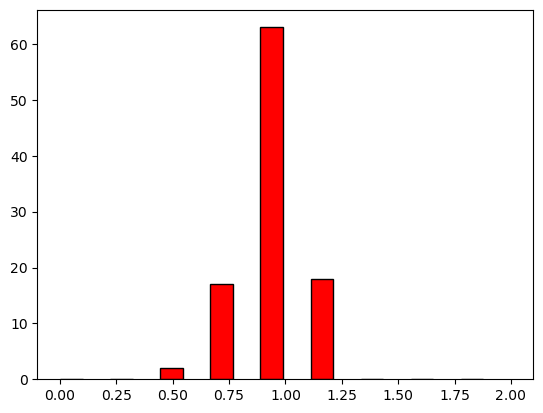

In [34]:
plt.hist(areas, bins=np.linspace(0,2,10),width=0.1,edgecolor='k', facecolor='red')

Calculate texture tensor

In [27]:
M = MTensor('final.json')

Save $\hat{M}$ into a VTK file and visualise it as ellipses.

In [28]:
M.plot_vtk_ellipse('M_ellipses.vtp', scale = 0.25)

Plot the configuration and the M tensor.

In [30]:
import matplotlib.pyplot as plt
import pyvista as pv
cmap = plt.cm.get_cmap("winter", 20)
p = pv.Plotter()
p.add_mesh(pv.read('cells_p0_3.850_v0_2.00_000499.vtp'), 
        scalars='Area',
        show_edges=True,
        line_width = 1,
        cmap=cmap,
        )
p.add_mesh(pv.read('M_ellipses.vtp'))
p.camera_position = 'xy'
p.show()

/var/folders/m1/0dcyjgv515j5kwn3zj48yl9h0000gq/T/ipykernel_69299/2748919267.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("winter", 20)


Widget(value="<iframe src='http://localhost:50354/index.html?ui=P_0x335d27790_4&reconnect=auto' style='width: …